# hodgkin–huxley model

## Introduction

In this notebook we will use a model of voltage-gated ion channels in a single neuron to simulate action potentials. The model is based on the work by Hodgkin & Huxley in the 1940s and 1950s. A good reference to refresh your memory about how ion channels in a neuron work is the Kandel, Schwartz & Jessel book "Principles of Neural Science". However, we strongly recommend that you read the orininal Hodking and Huxley publication!! it is beautiful, and very well explained: 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1392413/

Now, to the problem. 

Our goal here is to code up a dynamical model of the membrane's electric circuit including two types of ion channels: sodium and potassium channels. We will use this model to better understand the process underlying the origin of an action potential.

Remember that the current going through a patch of membrane can be described by the pasive properties of such membrane (capacitance and leak resistance), plus the contribution of the voltage dependent conductances (the sodium and potassium ion channels):

Similar to the membrane equation in the integrate-and-fire unit we now have:  

\begin{equation} C_{m}\frac{dV}{dt} = - g_{L}(V-E_{leak}) - I_{Na} - I_{K} + I_{inj} \end{equation}


### Sodium channels (Na)

The current through sodium channels that enter the soma is defined as:

\begin{equation} I_{Na} =g_{Na}m^{3}h(V - E_{Na})\end{equation}
where $m$ is the activation of the sodium channel and $h$ is the inactivation of the sodium channel, and the other terms are constant parameters: $E_{Na}$ is the reversal potential (the point of equilibrium for sodium channels), $g_{Na}$ is the maximum sodium conductance throught the membrane, and $V$ is the membrane potential of the soma.

The activation $m$ of the sodium channels is described by the differential equation:

\begin{equation} \frac{dm}{dt} = \alpha_{m}(1-m) - \beta_{m}m \end{equation}
where $\alpha_{m}$ represents the rate at which the channel switches from a closed to an open state, and $\beta_{m}$ is rate for the reverse. These two parameters $\alpha$ and $\beta$ depend on the membrane potential in the soma. In other words the sodium channel is voltage-gated. 

We did not cover this in the class, but the sodium channel is a bit more complex than the potassium channel. It does not only has an activation variable, but also presents inactivation (meaning that it innactivates with more voltage at the same time that inactivates). Without this additional therm the action potential could not be terminated. The inactivation of the sodium channels is described by a similar set of equations: a differential equation giving the rate of change of the sodium channel deactivation:

\begin{equation} \frac{dh}{dt} = \alpha_{h}(1-h) - \beta_{h}h \end{equation}
and equations specifying how $\alpha_{h}$ and $\beta_{h}$ are voltage-dependent (see the code below for the exact formulas of these values, which are bolzmann exponential functions). Hodking and huxley figured them out by fitting the experimental data that they cleverly collected. 

So in summary, for the sodium channels, we have two state variables: $(m,h)$ representing the activation $(m)$ and deactivation $(h)$ of the sodium channels. We have a differential equation for each, describing how the rate of change (the first derivative) of these states can be calculated

### Potassium channels (K)

The potassium channels are represted in a similar way, although in this case there is only channel activation, and no inactivation:

\begin{equation} I_{k} = g_{k}n^{4}(V-E_{k}) \end{equation} 

And the probability n is defined again as:

\begin{equation} \frac{dn}{dt} = \alpha_{n}(1-n) - \beta_{n}n \end{equation}
where \(n\) is the state variable representing the activation of potassium channels. As before we have expressions for $(\alpha,\beta)$ which represent the fact that the potassium channel is also voltage-gated.

To summarize, the potassium channel has a single state variable $(n)$ representing the activation of the potassium channel.

Remember also that the fact that $n$ and $m$ are raised to the power of 4 and to the power of 3 was done by Hodking and Huxley to properly fit the experimental data. It can be interpreted as a single ion channel having multiple gates that can open or close. The proteic structure of the potassium channel has indeed revealed that it is conformed of 4 voltage dependent domains. 

Enjoy the model! 

# Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

Define the constants and the time step of ODE

In [2]:
dt = 0.01      # time step
T = 10000       # total running step
C_m = 1.       # membrane capacitance (microF/cm**2)
G_k = 40.      # max K conductance (mS/cm**2)
G_l = 0.24     # max leak onductance (mS/cm**2)
G_na = 120.    # max Na conductance (mS/cm**2)
E_k = -12.0    # K reversal potential (mV)
E_l = 10.613   # leak potential (mV)
E_na = 115.    # Na reversal potential (mV)

4 eqs of Hodgkin-Huxley model  
* $C_M\displaystyle \frac{dV}{dt}= - g_l(V-V_l) - g_{Na}m^{3}h(V-V_{Na}) - g_{k}n^{4}(V-V_K) + I_inj$ ($V$: Membrane Potential)  
* $\displaystyle \frac{dh}{dt}=\alpha_h{(V)}(1-h)-\beta_h(V)h$ ($h$: Na Inactivation)  
* $\displaystyle \frac{dm}{dt}=\alpha_m{(V)}(1-m)-\beta_m(V)m$ ($m$: Na Activation)  
* $\displaystyle \frac{dn}{dt}=\alpha_n{(V)}(1-n)-\beta_n(V)n$ ($n$: K Activation)  

In [3]:
def dv(v, param, dt):
    h, m, n, i = param
    gna = G_na * h * (m**3)
    gk = G_k * (n**4)
    gl = G_l
    ina = gna * (v - E_na)
    ik = gk * (v - E_k)
    il = gl * (v - E_l)
    return (- ina - ik - il + i) * dt / C_m

def dh(h, param, dt):
    v = param
    alph = 0.07 * np.exp(-v / 20)
    beth = 1. / (np.exp((30 - v) / 10) + 1)
    return (alph * (1 - h) - beth * h) * dt

def dm(m, param, dt):
    v = param
    alpm = 0.1 * (25 - v) / (np.exp((25 - v) / 10) - 1)
    betm = 4. * np.exp(-v / 18)
    return (alpm * (1 - m) - betm * m) * dt

def dn(n, param, dt):
    v = param
    alpn = 0.01 * (10 - v) / (np.exp((10 - v) / 10) - 1)
    betn = 0.125 * np.exp(-v / 80)
    return (alpn * (1 - n) - betn * n) * dt

Update the variables by a 4th order Runge–Kutta method. This numerical method is more exact than the Euler method to solve differential equations. We will not cover this method in this class, but for more information visit:  
https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods

In [4]:
def rk4(f, y, param, dt):
    k1 = f(y, param, dt)
    k2 = f(y + dt * k1 * 0.5, param, dt)
    k3 = f(y + dt * k2 * 0.5, param, dt)
    k4 = f(y + dt * k3, param, dt)
    return (k1 + 2*k2 + 2*k3 + k4) / 6

def update(v, h, m, n, i, dt):
    v += rk4(dv, v, (h, m, n, i), dt)
    h += rk4(dh, h, v, dt)
    m += rk4(dm, m, v, dt)
    n += rk4(dn, n, v, dt)
    return v, h, m, n

Initialize the variables

In [5]:
vt = 0. # membrane potential (mV)
mt = 0. # Na channel activation (dimensionless)
nt = 0. # K channel activation (dimensionless)
ht = 0. # Na channel inactivation (dimensionless)
# total membrane current (microA/cm**2)
it = [0]*1000 + [10] * 500 + [0] * (T - 1500)
#it = [0] * 1000 + [-5] * 2000 + [0] * (T - 3000)

Define membrane current

Text(0.5, 1.0, 'Membrane Current $I$')

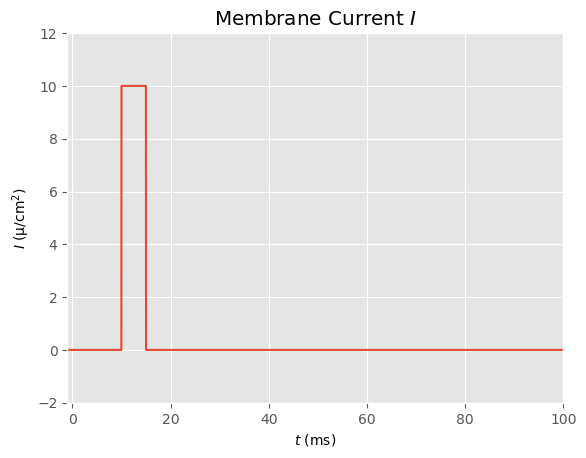

In [6]:
plt.xlabel('$t$ (ms)')
plt.ylabel('$I$ $\mathrm{(\mu/cm^2)}$')
plt.xlim(-1, T*dt)
plt.ylim(-2, 12)
xticks = [x * dt for x in range(-500, 0)] + [x * dt for x in range(T)]
plt.plot(xticks, [0]*500 + it)
plt.title('Membrane Current $I$')
#plt.savefig('1current.png', dpi=144)

Get the values in each time step

In [7]:
vts, hts, mts, nts = ([] for i in range(4))
for t in range(int(100 // dt)):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=0, dt=dt)
    # dispose of the results for 100 (ms)
for t in range(T):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=it[t], dt=dt)
    vts.append(vt)
    hts.append(ht)
    mts.append(mt)
    nts.append(nt)

Membrane potential

Text(0.5, 1.0, 'Membrane Potential $V$')

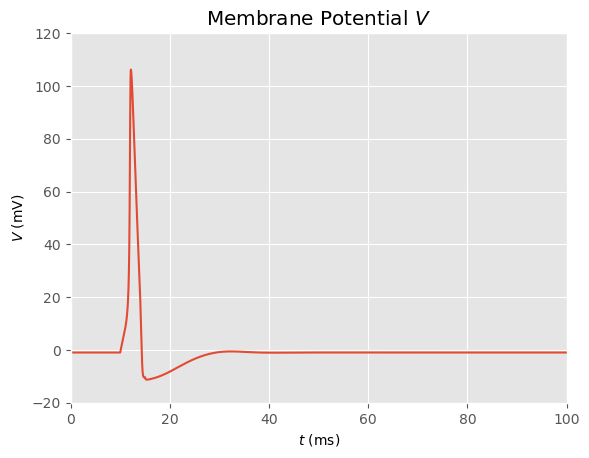

In [8]:
plt.xlabel('$t$ (ms)')
plt.ylabel('$V$ (mV)')
plt.xlim(0, dt*T)
plt.ylim(-20, 120)
xticks = [x * dt for x in range(T)]
plt.plot(xticks, vts)
plt.title('Membrane Potential $V$')
#plt.savefig('1potential.png', dpi=144)

Each channel activation

Text(0.5, 1.0, 'Ion Channel Activation')

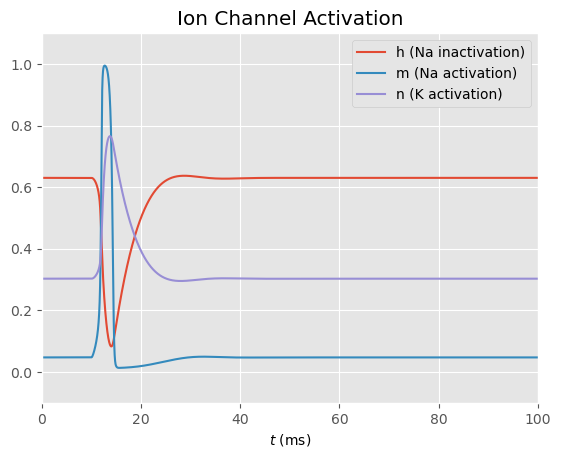

In [9]:
plt.xlabel('$t$ (ms)')
plt.xlim(0, dt*T)
plt.ylim(-0.1, 1.1)
xticks = [x * dt for x in range(T)]
plt.plot(xticks, hts)
plt.plot(xticks, mts)
plt.plot(xticks, nts)
plt.legend(['h (Na inactivation)', 'm (Na activation)',
            'n (K activation)'], bbox_to_anchor=(1, 1), framealpha=1)
plt.title('Ion Channel Activation')
#plt.savefig('1actv.png', dpi=144)

## Exercise 1

The combination of activations and inactivations of ion channels in biological membranes can confer neurons with some interesting behaviors. One of them is called "reboud spiking". Physiologists realised that when injecting a negative current pulse neurons would spike at the offset of such pulse. Could you reproduce this behavior in the model? Do you understand why is happening? 

## Multiple spiking

In [10]:
vt = mt = nt = ht = 0.
it = [10] * T
vts, hts, mts, nts = ([] for i in range(4))
for t in range(int(100 // dt)):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=0, dt=dt)
for t in range(T):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=it[t], dt=dt)
    vts.append(vt)
    hts.append(ht)
    mts.append(mt)
    nts.append(nt)

Text(0.5, 1.0, 'Membrane Current $I$')

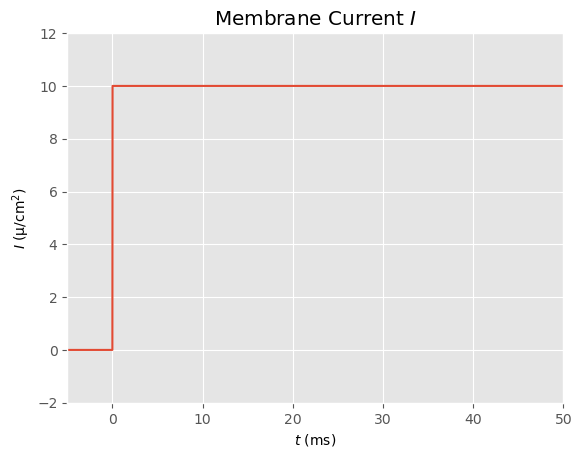

In [11]:
plt.xlabel('$t$ (ms)')
plt.ylabel('$I$ $\mathrm{(\mu/cm^2)}$')
plt.xlim(-5, 50)
plt.ylim(-2, 12)
xticks = [x * dt for x in range(-500, 0)] + [x * dt for x in range(T)]
plt.plot(xticks, [0]*500 + it)
plt.title('Membrane Current $I$')
#plt.savefig('2current.png', dpi=144)

Text(0.5, 1.0, 'Membrane Potential $V$')

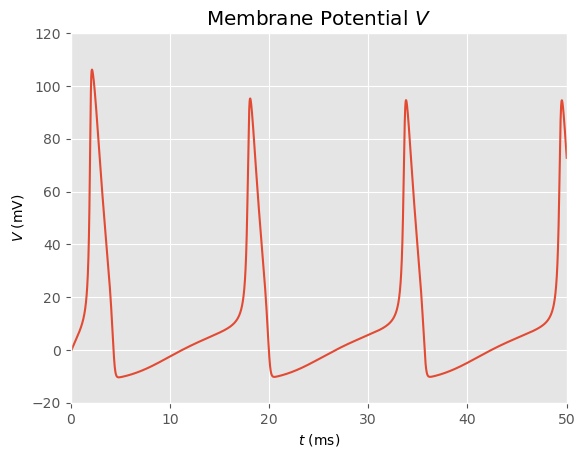

In [12]:
plt.xlabel('$t$ (ms)')
plt.ylabel('$V$ (mV)')
plt.xlim(0, 50)
plt.ylim(-20, 120)
xticks = [x * dt for x in range(T)]
plt.plot(xticks, vts)
plt.title('Membrane Potential $V$')
#plt.savefig('2potential.png', dpi=144)

# Exercise 2

Another property of biological neurons is that after every spike they take some time "to recover" this is refered
as to the refractory period. 
Can you show the refractory period in this model? 
Hint: you should inject the neuron with three consecutive short pulses. Play with the frequency of those pulses. 

## Refractory Period

In [13]:
vt = mt = nt = ht = 0.
it = ([10] * 200 + [0] * 800) * (T // 1000)
vts, hts, mts, nts = ([] for i in range(4))
for t in range(int(100 / dt)):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=0, dt=dt)
for t in range(T):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=it[t], dt=dt)
    vts.append(vt)
    hts.append(ht)
    mts.append(mt)
    nts.append(nt)

Text(0.5, 1.0, 'Membrane Current $I$')

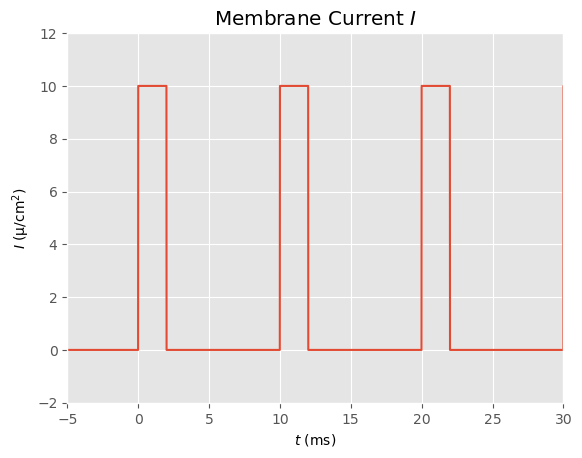

In [14]:
plt.xlabel('$t$ (ms)')
plt.ylabel('$I$ $\mathrm{(\mu/cm^2)}$')
plt.xlim(-5, 30)
plt.ylim(-2, 12)
xticks = [x * dt for x in range(-500, 0)] + [x * dt for x in range(T)]
plt.plot(xticks, [0]*500 + it)
plt.title('Membrane Current $I$')
#plt.savefig('3current.png', dpi=144)

Text(0.5, 1.0, 'Membrane Potential $V$')

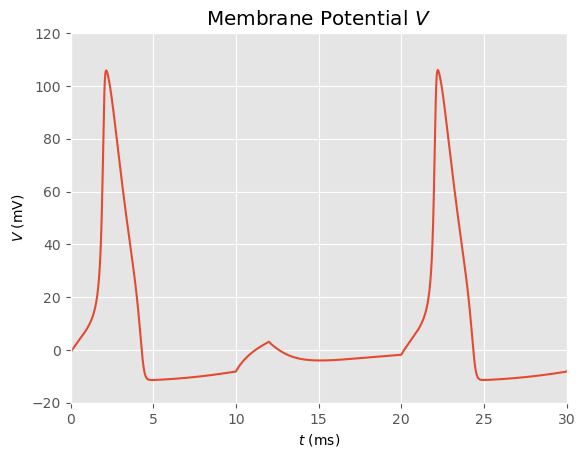

In [15]:
plt.xlabel('$t$ (ms)')
plt.ylabel('$V$ (mV)')
plt.xlim(0, 30)
plt.ylim(-20, 120)
xticks = [x * dt for x in range(T)]
plt.plot(xticks, vts)
plt.title('Membrane Potential $V$')
#plt.savefig('3potential.png', dpi=144)